In [1]:
import numpy as np

# 6.1 パラメータの効率的な更新，最適化
- optimizerを実装して，重みパラメータと勾配を渡して更新する
- optimizerを変えるだけで，異なる最適化アルゴリズムを使える

***
### Momentum
$$
\boldsymbol{v} \leftarrow \alpha \boldsymbol{v} - \eta \frac{\partial L}{\partial W}
\\ \\
W \leftarrow W + \boldsymbol{v}
$$

- $W$: 更新する重みパラメータ
- $\eta$: 学習率．インスタンス変数として
- $\boldsymbol{v}$: 速度にあたる変数．
- $\alpha$: 減速させる役割をもつ定数．(0.9などを使う)

In [2]:
class Momentum:
    def __init__(self, lr=0.01, momentum=0.9):
        # 初期化．速度の初期値はNone
        self.lr = lr
        self.momentum = momentum
        self.v = None
        
    def update(self, params, grads):
        # 初回更新時，vにparamsと同じ形状のデータをディクショナリとして持たせる
        if self.v is None:
            self.v = {}
            for key, val in params.items():
                self.v[key] = np.zeros_like(val)
                
        # paramsとvを更新する
        for key in params.keys():
            # 前回のvはmomentum分だけ減速，現在のparamsを元にした勾配で速度を更新
            self.v[key] = self.momentum * self.v[key] - self.lr * grads[key]
            # 更新後の速度でparamsを更新
            params[key] += self.v[key]

***
### AdaGrad
$$
\boldsymbol{h} \leftarrow \boldsymbol{h} + \frac{\partial L}{\partial W} \otimes \frac{\partial L}{\partial W}
\\ \\
W \leftarrow W - \eta \frac{1}{\sqrt{\boldsymbol{h} + \epsilon}} \frac{\partial L}{\partial W}
$$

- $\otimes$ は要素ごとの積（アダマール積）を表す
- 学習率を減衰させる発想
- $\boldsymbol{h}$ は過去の勾配の2乗和を記憶していく
- 重みパラメータの更新の際には勾配を$\boldsymbol{h}$ で割ることで，徐々に更新の度合いを小さくする．平方根を取るのはスケールの調整．
- 無限に更新すると更新量が0になる．改良した手法としてRMSPropがある．

***
### RMSProp
$$
\boldsymbol{h} \leftarrow \beta \boldsymbol{h} + (1 - \beta) \frac{\partial L}{\partial W} \otimes \frac{\partial L}{\partial W}
\\ \\
W \leftarrow W - \eta \frac{1}{\sqrt{\boldsymbol{h} + \epsilon}} \frac{\partial L}{\partial W}
$$
- $\beta$ に0.9などの値を入れて，過去の勾配の影響を低下させ，新しい勾配の影響を大きくする


In [3]:
class AdaGrad:
    def __init__(self, lr=0.01):
        self.lr = lr
        self.h = None
        
    def update(self, params, grads):
        if self.h is None:
            self.h = {}
            for key, val in params.items():
                self[key] = np.zeros_like(val)
                
        for key in params.keys():
            self.h[key] += grads[key] * grads[key]
            params[key] -= self.lr * grads[key] / (np.sqrt(self.h[key]) + 1e-7)

***
### Adam
$$
\begin{align}
\boldsymbol{m}_t &\leftarrow \beta_1 \boldsymbol{m}_{t-1} + (1 - \beta_1) \frac{\partial L}{\partial W}
\\ \\
\boldsymbol{v}_t &\leftarrow \beta_2 \boldsymbol{v}_{t-1} + (1 - \beta_2) \frac{\partial L}{\partial W} \otimes \frac{\partial L}{\partial W}
\\ \\
\boldsymbol{\hat{m}}_t &\leftarrow \frac{\boldsymbol{m}_t}{(1 - \beta_1^t)}
\\ \\
\boldsymbol{\hat{v}}_t &\leftarrow \frac{\boldsymbol{v}_t}{(1 - \beta_2^t)}
\\ \\
W_t &\leftarrow W_{t-1} - \eta \frac{\boldsymbol{\hat{m}}_t}{\sqrt{\boldsymbol{\hat{v}}_t} + \epsilon}
\end{align}
$$

- [原著論文](https://paperswithcode.com/paper/adam-a-method-for-stochastic-optimization)
- MomentumとAdaGradの組み合わせ
- $\boldsymbol{m}$ はモーメント．勾配の移動平均．速度を保持．
- $\boldsymbol{v}$ は更新量．勾配の大きさの移動平均．過去のイテレーションで勾配が大きかったパラメータの更新量は小さく，勾配が小さかったパラメータの更新量は大きく調整．
- $\boldsymbol{m}, \ \boldsymbol{v}$ を $(1 - \beta^t)$ で割ることで，イテレーションの初期では大きく，イテレーションが進むほど小さくなるよう調整する．$\boldsymbol{m}_0, \ \boldsymbol{v}_0$ は0から始まるため，$t = 1$ のときなど，$\boldsymbol{m}, \ \boldsymbol{v}$ は非常に小さい値になってしまう．

***
### 最適化アルゴリズムの比較

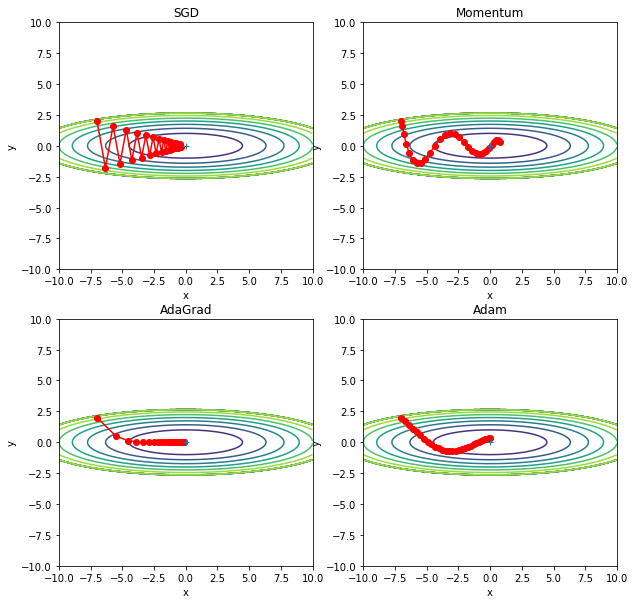

In [4]:
# coding: utf-8
import sys, os
sys.path.append(os.pardir)  # 親ディレクトリのファイルをインポートするための設定
import matplotlib.pyplot as plt
from collections import OrderedDict
from common.optimizer import *

%matplotlib inline


def f(x, y):
    return x**2 / 20.0 + y**2


def df(x, y):
    return x / 10.0, 2.0*y

init_pos = (-7.0, 2.0)
params = {}
params['x'], params['y'] = init_pos[0], init_pos[1]
grads = {}
grads['x'], grads['y'] = 0, 0


optimizers = OrderedDict()
optimizers["SGD"] = SGD(lr=0.95)
optimizers["Momentum"] = Momentum(lr=0.1)
optimizers["AdaGrad"] = AdaGrad(lr=1.5)
optimizers["Adam"] = Adam(lr=0.3)

idx = 1
plt.figure(figsize=(10, 10))

for key in optimizers:
    optimizer = optimizers[key]
    x_history = []
    y_history = []
    params['x'], params['y'] = init_pos[0], init_pos[1]
    
    for i in range(30):
        x_history.append(params['x'])
        y_history.append(params['y'])
        
        grads['x'], grads['y'] = df(params['x'], params['y'])
        optimizer.update(params, grads)
    

    x = np.arange(-10, 10, 0.01)
    y = np.arange(-5, 5, 0.01)
    
    X, Y = np.meshgrid(x, y) 
    Z = f(X, Y)
    
    # for simple contour line  
    mask = Z > 7
    Z[mask] = 0
    
    # plot 
    plt.subplot(2, 2, idx)
    idx += 1
    plt.plot(x_history, y_history, 'o-', color="red")
    plt.contour(X, Y, Z)
    plt.ylim(-10, 10)
    plt.xlim(-10, 10)
    plt.plot(0, 0, '+')
    #colorbar()
    #spring()
    plt.title(key)
    plt.xlabel("x")
    plt.ylabel("y")
    
plt.show()

# 6.2 重みの初期値
- 重みをなるべく小さくすることで，過学習が起きにくくなる（Weight decay = 荷重減衰）
- 初期値を均一な値にしてはいけない．全ての重みが均一に更新される

Affine変換 $\boldsymbol{x} W + \boldsymbol{b}= \boldsymbol{a}$ において，重みが均一な場合，次の層への出力，backpropの勾配が均一になる

中間層の全ノードへの入力が同じであるということは，複数のノードが存在する意味がなくなるということ

***
### 隠れ層のアクティベーション分布
##### 重みの初期値にガウス分布を用いて，その標準偏差を変えたときに隠れ層のアクティベーション関数の出力の分布がどう変化するかを観察
- 5層，各層は100個のニューロンを持つニューラルネットワークで実験

##### 活性化関数: Sigmoid
- 出力が0や1に偏りすぎると，勾配の値が小さくなり勾配消失に至る
- 出力が0.5付近であっても，同じ出力ばかりだとニューロンの多様性が失われ，表現力が制限される
- 前層ノード数を $n$ としたとき，$\sqrt{\frac{1}{n}}$ の標準偏差を持つ分布を使う:「Xavierの初期値」
- Xavierの初期値は活性化関数が線形であることを前提としたものだが，Sigmoidは中央付近が線形とみなせるため効果がある．

##### 活性化関数: ReLU
- ReLUに適したHeの初期値が使われる
- 前層ノード数を $n$ としたとき，$\sqrt{\frac{2}{n}}$ の標準偏差を持つ分布を使う
- 直観的な解釈: ReLUでは入力が負の場合は全て出力0になる＝多様性が低いため初期値のばらつきを大きくとる

***
#### 実験: アクティベーション関数の種類，初期値の正規分布の標準偏差を変えて出力の分布を確認する

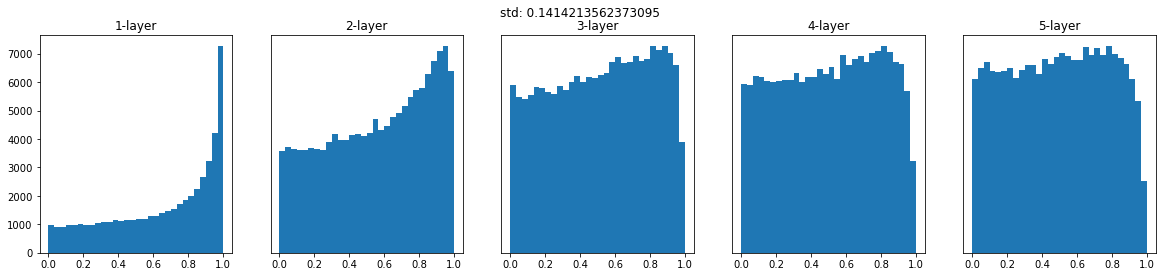

In [31]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def ReLU(x):
    return np.maximum(0, x)


def tanh(x):
    return np.tanh(x)
    
input_data = np.random.randn(1000, 100)  # 1000個のデータ
node_num = 100  # 各隠れ層のノード（ニューロン）の数
hidden_layer_size = 5  # 隠れ層が5層
activations = {}  # ここにアクティベーションの結果を格納する

x = input_data

for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i-1]

    # 初期値の値をいろいろ変えて実験しよう！
#     std = 1
#     std = 0.01
#     std = np.sqrt(1.0 / node_num) # Sigmoid 最適
    std = np.sqrt(2.0 / node_num) # ReLU 最適

    w = np.random.randn(node_num, node_num) * std

    a = np.dot(x, w)


    # 活性化関数の種類も変えて実験しよう！
#     z = sigmoid(a)
#     z = ReLU(a)
    z = tanh(a)

    activations[i] = z

# ヒストグラムを描画
plt.figure(figsize=(20, 4))
plt.suptitle('std: ' + str(std))
for i, a in activations.items():
    plt.subplot(1, len(activations), i+1)
    plt.title(str(i+1) + "-layer")
    if i != 0: plt.yticks([], [])
    # plt.xlim(0.1, 1)
    # plt.ylim(0, 7000)
    plt.hist(a.flatten(), 30, range=(0,1))
plt.show()

***
# 6.3 Batch Normalization
$$
\begin{align}
\mu_{j} &\leftarrow \frac{1}{n} \Sigma_{i=1}^{n} x_{ij}
\\ \\
\sigma_{j}^2 &\leftarrow \frac{1}{n} \Sigma_{i=1}^{n} (x_{ij} - \mu_{j})^2
\\ \\
\hat{x}_{ij} &\leftarrow \frac{x_{ij} - \mu_{j}}{\sqrt{\sigma_{j}^2 + \epsilon}}
\\ \\
y_{ij} &\leftarrow \gamma_j \hat{x}_{ij} + \beta_j
\end{align}
$$
- アクティベーション関数の出力分布を調整する手法
- ミニバッチとして，サンプル数 $n$，次元 $m$ の以下の入力を考える（ノード数 $m$ である層からの出力）
$$
B = 
\begin{pmatrix}
x_{11} & x_{12} & \cdots & x_{1m} \\
x_{21} & x_{22} & \cdots & x_{2m} \\
\vdots & \vdots & & \vdots \\
x_{n1} & x_{n2} & \cdots & x_{nm} \\
\end{pmatrix}
$$


- 入力データの各成分のミニバッチ全体の平均 $\mu_j$，分散 $\sigma_j$ を求める
- $\mu_j, \ \sigma_j$ を使って，データを標準化し，平均0，分散1にする（$\epsilon$ は0除算を防ぐため）
- 最後に固有のスケールとシフトで変換する．$\gamma, \ \beta$ はパラメータ．平均 $\beta$，分散 $\gamma$ になる？

***

#### 偏微分導出
- $\mu_{j} \leftarrow \frac{1}{n} \Sigma_{i=1}^{n} x_{ij}$ について
$$
\mu_{j} = \frac{1}{n} (x_{1j} + x_{2j} + \cdots + x_{nj})
$$
より
$$
\frac{\partial \mu_{j}}{\partial x_{ij}} = \frac{1}{n}
$$
<br><br>


- $\sigma_{j}^2 \leftarrow \frac{1}{n} \Sigma_{i=1}^{n} (x_{ij} - \mu_{j})^2$ について
$$
\begin{align}
    \frac{\partial \sigma_{j}^2}{\partial x_{ij}} 
        &= \frac{1}{n} \left\{
            \frac{\partial (x_{1j} - \mu_j)^2}{\partial x_{ij}} + \frac{\partial (x_{2j} - \mu_j)^2}{\partial x_{ij}} + \cdots + \frac{\partial (x_{nj} - \mu_j)^2}{\partial x_{ij}}
        \right\}
        \\
        &= \frac{1}{n} \Sigma_{\lambda=1}^{n} \frac{\partial (x_{\lambda j} - \mu_j)^2}{\partial x_{ij}}
        \\
        &= \frac{2}{n} \Sigma_{\lambda=1}^{n} (x_{\lambda j} - \mu_{j}) \frac{\partial (x_{\lambda j} - \mu_j)}{\partial x_{ij}}
        \\
        &= \frac{2}{n} \Sigma_{\lambda=1}^{n} (x_{\lambda j} - \mu_{j}) \left( \frac{\partial x_{\lambda j}}{\partial x_{ij}} - \frac{\partial \mu_j}{\partial x_{ij}} \right)
        \\
        &= \frac{2}{n} \Sigma_{\lambda=1}^{n} (x_{\lambda j} - \mu_{j}) \left( \delta_{i \lambda} - \frac{1}{n} \right)
        \\
        &= \frac{2}{n} \Sigma_{\lambda=1}^{n} \delta_{i \lambda} (x_{\lambda j} - \mu_{j}) - \frac{2}{n^2} \Sigma_{\lambda=1}^{n} (x_{\lambda j} - \mu_{j})
        \\
        &= \frac{2}{n} (x_{ij} - \mu_{j}) - \frac{2}{n} \left( \frac{1}{n} \Sigma_{\lambda=1}^{n} x_{\lambda j} - \frac{1}{n} \Sigma_{\lambda=1}^{n} \mu_j \right)
        \\
        &= \frac{2}{n} (x_{ij} - \mu_{j}) - \frac{2}{n} (\mu_j - \mu_j)
        \\
        &= \frac{2}{n} (x_{ij} - \mu_{j})
\end{align}
$$
<br><br>



- $\hat{x}_{ij} \leftarrow \frac{x_{ij} - \mu_{j}}{\sqrt{\sigma_{j}^2 + \epsilon}}$ について

$s_j = \sqrt{\sigma_j^2 + \epsilon}$ とおけば 

$$
\begin{align}
    \frac{\partial s_j}{\partial x_{ij}}
        &= \frac{\partial s_j}{\partial \sigma_j^2} \frac{\partial \sigma_j^2}{\partial x_{ij}}
        \\
        &= \frac{1}{2 \sqrt{\sigma_j^2 + \epsilon}} \frac{2}{n} (x_{ij} - \mu_{j})
        \\
        &= \frac{x_{ij} - \mu_{j}}{n s_j}
    \\
    \\
    \frac{\partial \hat{x}_{kj}}{\partial x_{ij}}
        &= \frac{1}{s_j^2} \left\{
            s_j \frac{\partial (x_{kj} - \mu_{j})}{\partial x_{ij}} - \frac{\partial s_j}{\partial x_{ij}} (x_{kj} - \mu_{j})
        \right\}
        \\
        &= \frac{1}{s_j^2} \left\{
            s_j \left( \delta_{ik} - \frac{1}{n} \right) - \frac{x_{ij} - \mu_{j}}{n s_j} (x_{kj} - \mu_{j})
        \right\}
        \\
        &= \frac{1}{s_j} \left\{
            \delta_{ik} - \frac{1}{n} - \frac{(x_{ij} - \mu_{j})(x_{kj} - \mu_{j})}{n s_j^2}
        \right\}
        \\
        &= \frac{1}{s_j} \left(
            \delta_{ik} - \frac{1}{n} - \frac{\hat{x}_{ij} \hat{x}_{kj}}{n}
        \right)
\end{align}
$$
<br><br>


- $y_{ij} \leftarrow \gamma_j \hat{x}_{ij} + \beta_j$ について
$$
\begin{align}
    \frac{\partial y_{kj}}{\partial x_{ij}}
        &= \frac{\partial y_{kj}}{\partial \hat{x}_{kj}} \frac{\partial \hat{x}_{kj}}{\partial x_{ij}}
        \\
        &= \frac{\gamma_j}{s_j} \left(
            \delta_{ik} - \frac{1}{n} - \frac{\hat{x}_{ij} \hat{x}_{kj}}{n}
        \right)
    \\
    \\
    \frac{\partial y_{kj}}{\partial \beta_j} &= 1
    \\
    \\
    \frac{\partial y_{kj}}{\partial \gamma_j} &= \hat{x}_{kj}
\end{align}
$$
<br><br>


- 損失関数 $L$ の偏微分

第 $j$ ノードに対する損失は $y_{1j}, y_{2j}, \cdots, y_{nj}$ の関数

出力 $y_{ij}$ は $x_{1j}, x_{2j}, \cdots, x_{nj}$ の関数

$$
\begin{align}
    \frac{\partial L}{\partial x_{ij}}
        &= \Sigma_{\lambda=1}^{n} \frac{\partial L}{\partial y_{\lambda j}} \frac{\partial y_{\lambda j}}{\partial x_{ij}}
        \\
        &= \Sigma_{\lambda=1}^{n} \frac{\partial L}{\partial y_{\lambda j}} \frac{\gamma_j}{s_j} \left(
            \delta_{i \lambda} - \frac{1}{n} - \frac{\hat{x}_{ij} \hat{x}_{\lambda j}}{n}
        \right)
        \\
        &= \frac{\gamma_j}{s_j} \left\{
            \frac{\partial L}{\partial y_{ij}} - \frac{1}{n} \Sigma_{\lambda=1}^{n} (1 + \hat{x}_{ij} \hat{x}_{\lambda j}) \frac{\partial L}{\partial y_{\lambda j}}
        \right\}
\end{align}
$$